We formulate a 3D ODE for photosynthesis that explicitly tracks the concentrations
of $[R]$, $[ATP]$, and $[H^+]$ (the proton concentration, which modulates $j_{PQ}$.
We use mass conservation laws to track the concentrations of $[ADP]$, $[P_i]$, and
$[PGA]$:
<br>
Conservation of phosphate:
$$
C_1 = 2*[R] + [PGA] + [P_i] + [ATP] 
$$
Exchange of ADP/ATP:
$$
C_2 = [ATP] + [ADP]
$$
Equation for photochemical quenching flux $j_{PQ}$:
$$
j_{PQ} = \frac{k_{PQ}}{k_{PQ} + k_{f} + k_{NPQ}}I
$$
where $I$ is the incident light flux and the terms in the numerator and denominator
are the probabilities of photochemical quenching, flourescence, and NPQ. Thus 
$k_{PQ} = 1 - k_{NPQ} - k_{f}$. $k_{NPQ}$ depends on $[H^+]$:
$$
k_{NPQ} = (1-k_f)\frac{k^*_{NPQ}[H^+]}{k^*_{NPQ}[H^+] + 1}
$$
Thus k_{NPQ} will increase with $[H^+]$ and saturate at $1-k_{f}$. 
<br>
ATP is synthesized via the ATP Synthase SU, which processes ADP, P$_i$, and protons
to produce ATP:
$$
j_{ATP-syn} = \frac{[E_{syn}]}{\frac{1}{k_{syn}} + \frac{3}{f([ADP])} + 
\frac{12}{f([H^+])} + \frac{3}{f([P_i])} - \frac{1}{f([ADP])/3+f([H^+])/12}
 - \frac{1}{f([ADP])/3 + f([P_i])/3} - \frac{1}{f([P_i])/3+f([H^+])/12} 
+ \frac{1}{f([ADP])/3+f([P_i])/3+f([H^+])/12}}
$$
Where $f(A)$ is the diffusion rate of substrate A with binding rate $k^+_A$:
$f(A) = k^+_A[A].$
 $E_{syn}$ is the concentration of
ATP Synthase, and $k_{syn}$ is its rate of production. 
<br>
RuBP is consumed via Carboxylation and Oxygenation and is regenerated via the RuBP
regeneration SU, which also consumes ATP and regenerates P$_i$ and $[ADP]$ (we
assume here that all of the orthophosphate that is consumed to produce ATP is regenerated
along with RuBP. We do not yet explicitly model starch and sucrose synthesis.)
$$
j_{cA} = \frac{d[C]}{dt} = \frac{E_t}{1/k_{ERC} + 1/(f(O) + f(C)) + 1/f(R) - 1/(f(C) + f(O) + f(R))}
$$
$$
j_{oA} = \frac{d[O]}{dt} = \frac{E_t}{1/k_{ERO} + 1/(f(O) + f(C)) + 1/f(R) - 1/(f(C) + f(O) + f(R))}
$$
and $j_{PGA-prod} = 2j_{cA} + 1.5j_{oA}$.
*(Note that $E_t$ and $k_{ERO}$ likely needs to approximate the reactions of the oxidative
pathway in addition to Carboxylation)*
<br>
The RuBP regeneration SU acts as a simplified SU of the many enzymatic reactions that
eventually convert PGA back to RuBP. 2 mol PGA and 3 mol ATP produce 1 mol RuBP.
$$
j_{RuBP-regen} = \frac{E_{CC}}{1/j_{CC} + 3/f(ATP) + 2/f(PGA) - \frac{1}{(f(ATP)/3 + f(PGA)/2}}
$$
Thus we have the following ODE system:
$$
\frac{d[R]}{dt} = j_{RuBP-regen} - \frac{8}{15}j_{PGA-prod} + j_{leak}
$$
where $j_{leak}$ is the RuBP lost to oxygenation. 
$$
\frac{d[ATP]}{dt} = 3j_{ATP-syn} - 3j_{RuBP-regen}
$$
$$
\frac{d[H^+]}{dt} = 3j_{PQ} - 12j_{ATP-syn}
$$


In [2]:
from scipy import integrate as spint
from scipy.optimize import fsolve
from sympy import Matrix
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets


from ipywidgets import interact, interact_manual
inv = np.linalg.inv
norm = np.linalg.norm
eye = np.identity

In [10]:
#Parameter values


#from Farquhar 1980

#turnover numbers for carboxylation and oxygenation
kERC = 2.5
kERO = .21*kERC

#turnover rate for carboxylation (1/s)
kc = 4.14*((10)**(-3))
#turnover rate for oxygenation (1/s)
ko = 7.57*(10**(-6))
#RuBP binding rate
kr = 2*(10**(-5))
#light intensity (umol)
I = 1000
#total enzyme concentration (umol/carboxylation site)
Et = 87.2
#CO2 concentration (ubar)
C = 230 
#O2 concentration (ubar)
O = 210 * 10**(3)




kprod = kc
kE = kc



kappac = 2/3
kappar = 1/3

ATPo = 200
Ro = 350
ADPo = 100
Po = 100
PGAo = 200
Ho = 100
#total ATP + ADP (umol)
OP = ATPo + ADPo
OPt = ATPo + Po
#total RuBP + intermediates (umol)
tot = 2*Ro + OPt + PGAo

Ecalvin = 100
Esyn = 100

kcalvin = 2
ki = 2
kAC = 2
kATP = 2
jsyn = 2
kp = 2
knpq = .02
kf = .05
kh = 2


In [11]:
#ODE system
def Hmodel(x, I = I, knpq = knpq, C=C, O=O, kr = kr, ATPo = ATPo, Ro = Ro, PGAo = PGAo, Po=Po, ADPo=ADPo):
    R, ATP, H = x[0], x[1], x[2]
    
    
    Hd = knpq*H
    fnpq = (1-kf)*(Hd/(1+Hd))
    jpq = (1 - (kf + fnpq))*I
    
    #total ATP + ADP (umol)
    OP = ATPo + ADPo
    OPt = ATPo + Po
    #total RuBP + intermediates (umol)
    tot = 2*Ro + OPt + PGAo
    
    P = OPt - ATP
    INte = tot - (ATP + 2*R + P)
    ADP = OP - ATP

    fC = kc*C
    fO = ko*O
    fR = kr*R
    #new = """
    jcA = Et/((1/kERC) + (1/(fC+fO)) + 1/fR - 1/(fC+fO+fR))
    joA = Et/((1/kERO) + (1/(fC+fO)) + 1/fR - 1/(fC+fO+fR))
    jPGAprod = 2*jcA + 1.5*joA
    #"""
    #ATP consumption
    jRuBPregen = Ecalvin/(1/kcalvin + 3/(kAC*ATP) + 2/(ki*INte) - 1/(ki*INte/2+kAC*ATP/3))
    
    #Pi consumption/ATP synthesis
    fATP = kATP*ADP/3
    fP = kp*P/3
    fH = kh*H/12
    jPcons = Esyn/(1/jsyn + 1/fATP + 1/fH + 1/fP - (1/(fH+fATP)+1/(fH+fP)+1/(fP+fATP)) + 1/(fH+fP+fATP))
    
    #this is the amount of phosphate lost due to oxygenation. See below
    leak = 232533.333333333/(20000/(20000*R + 2.54190000000000) - 1/R - 15868.1301388725) + 174400.000000000/(20000/(20000*R + 2.54190000000000) - 1/R - 45963.3682341106)
    
    cons = [jPGAprod, jRuBPregen, jPcons, jpq, leak]
    
    S = [[-8/15, 1, 0, 0, -1/2], [0, -3, 3, 0, 0], [0, 0, -12, 3, 0]]
    DEs = np.matmul(S, cons)
    return DEs, jpq

In [5]:

vs = ["R", "ATP", "H"]
dt = .001
steps = 10000

In [23]:
def findPGA(R, ATP, Ro=Ro, ADPo=ADPo, PGAo=PGAo, ATPo=ATPo, Po=Po):
    OPt = ATPo + Po
    P = OPt - ATP
    tot = 2*Ro + OPt + PGAo
    PGA =  tot - (ATP + 2*R + P)
    return PGA

In [34]:
#numerical simulation
@interact(dt = (.00001, .01, .00001), I=(0,2000,10), steps=(10, 50000, 1), knpq = (.001, 1, .001), kr = (.01, 20000, .01), Ho = (0,100, 1))
def simiter3(steps = steps, dt = dt, Ro = Ro, Ho=Ho, ATPo=ATPo, PGAo = PGAo, Po=Po, ADPo=ADPo, I=I, O=O, C=C, knpq=.5, kr = kr):
    x0 = [Ro, ATPo, Ho]
    a = len(x0)
    sol = np.zeros((steps, a))
    sol[0] = x0
    jpqlist = []
    for i in range(steps-1):
        DE, jpq = Hmodel(sol[i], I=I, knpq=knpq, C=C, O=O, kr =kr, ATPo = ATPo, Ro = Ro, PGAo = PGAo, Po=Po, ADPo=ADPo)
        step = DE*dt
        sol[i+1] = np.add(sol[i], step)
        jpqlist.append(jpq)
    print(sol[-1])
    check, jp = Hmodel(sol[-1], I=I, knpq=knpq, C=C, O=O, kr =kr, ATPo = ATPo, Ro = Ro, PGAo = PGAo, Po=Po, ADPo=ADPo)
    print(check, jp)
    
    PGAlist = [findPGA(x[0], x[1], Ro=Ro, ADPo=ADPo, PGAo=PGAo, ATPo=ATPo, Po=Po) for x in sol]
    
    for k in range(a):
        y = [x[k] for x in sol]
        plt.plot(range(steps), y, label="{}".format(vs[k]))
     
    R = sol[-1][0]
    fC = kc*C
    fO = ko*O
    fR = kr*R
    jcA = Et/((1/kERC) + (1/(fC+fO)) + 1/fR - 1/(fC+fO+fR))
    print(jcA)
    plt.plot(range(steps), PGAlist, label="PGA")
    plt.plot(range(steps-1), jpqlist, label = "jpq")
    plt.legend()
    plt.show()

interactive(children=(IntSlider(value=10000, description='steps', max=50000, min=10), FloatSlider(value=0.001,…

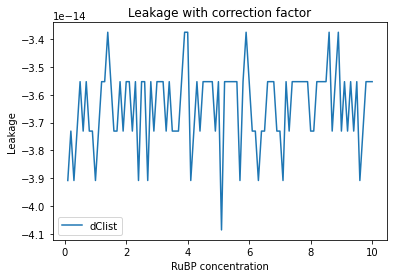

In [6]:
#Loss due to oxygenation per cycle
def oxyloss():
    R, ATP, H, P, INte, ADP = var("R, ATP, H, P, INte, ADP")
    
    Hd = knpq*H
    fnpq = (1-kf)*(Hd/(1+Hd))
    jpq = (1 - (kf + fnpq))*I
    
    

    fC = kc*C
    fO = ko*O
    fR = kr*R
    #new = """
    jcA = Et/((1/kERC) + (1/(fC+fO)) + 1/fR - 1/(fC+fO+fR))
    joA = Et/((1/kERO) + (1/(fC+fO)) + 1/fR - 1/(fC+fO+fR))
    jPGAprod = 2*jcA + 1.5*joA
    #"""
    #ATP consumption
    jRuBPregen = Ecalvin/(1/kcalvin + 3/(kAC*ATP) + 2/(ki*INte) - 1/(ki*INte/2+kAC*ATP/3))
    
    #Pi consumption/ATP synthesis
    fATP = kATP*ADP/3
    fP = kp*P/3
    fH = kh*H/12
    jPcons = Esyn/(1/jsyn + 1/fATP + 1/fH + 1/fP - (1/(fH+fATP)+1/(fH+fP)+1/(fP+fATP)) + 1/(fH+fP+fATP))
    
    leak = 232533.333333333/(20000/(20000*R + 2.54190000000000) - 1/R - 15868.1301388725) + 174400.000000000/(20000/(20000*R + 2.54190000000000) - 1/R - 45963.3682341106)
    
    cons = [jPGAprod, jRuBPregen, jPcons, jpq, leak]
    
    
    S = [[-8/15, 1, 0, 0, -1/2], [0, -3, 3, 0, 0], [0, 0, -12, 3, 0], [0, 3, -3, 0, 0], [1, -2, 0, 0, 0], [0, 3, -3, 0, 0] ]
    DEs = np.matmul(S, cons)
    
    
    
    dC = 2*DEs[0] + DEs[1] + DEs[3] + DEs[4]
    #leakage is equal to difference between increase in 2*R and that of PGA. So should maybe see under what cases one is greater than another? 
    #Well it's 2R + PGA so 
    #RuBP has two phosphates. ATP gives one phosphate and obviously Pi has one. Pretty sure PGA has three though?? PGA has one. Two moles of PGA are made from     one RuBP
    Rlist = np.linspace(0.1, 10, 100)
    dClist = [dC.subs(R==r) for r in Rlist]
    #leaklist = [leak.subs(R==r) for r in Rlist]
    #diff = dC - leak
    #difflist = [diff.subs(R==r) for r in Rlist]
    
    plt.plot(Rlist, dClist, label='dClist')
    #plt.plot(Rlist, leaklist, label='leaklist')
    #plt.plot(Rlist, difflist, label = 'difflist')
    plt.title("Leakage with correction factor")
    plt.xlabel("RuBP concentration")
    plt.ylabel('Leakage')
    plt.legend()
    plt.show()
    
oxyloss()

In [7]:
#now that we've added the correction factor to add a small amount to RuBP, the leakage is on a scale of 10^-14, likely due to rounding errors
def leak(R):
    leak = 232533.333333333/(20000/(20000*R + 2.54190000000000) - 1/R - 15868.1301388725) + 174400.000000000/(20000/(20000*R + 2.54190000000000) - 1/R - 45963.3682341106)
    return leak

In [15]:
#Jacobian for backward Euler
def dF(x):
    R, ATP, H = var("R, ATP, H")


    Hd = knpq*H
    fnpq = (1-kf)*(Hd/(1+Hd))
    jpq = (1 - (kf + fnpq))*I

    #total ATP + ADP (umol)
    OP = ATPo + ADPo
    OPt = ATPo + Po
    #total RuBP + intermediates (umol)
    tot = 2*Ro + OPt + PGAo

    P = OPt - ATP
    INte = tot - (ATP + 2*R + P)
    ADP = OP - ATP

    fC = kc*C
    fO = 2*ko*O/3
    fR = kr*R
    #new = """
    jcA = Et/((1/kERC) + (1/(fC+fO)) + 1/fR - 1/(fC+fO+fR))
    joA = Et/((1/kERO) + (1/(fC+fO)) + 1/fR - 1/(fC+fO+fR))
    jPGAprod = 2*jcA + 1.5*joA
    #"""
    #ATP consumption
    jRuBPregen = Ecalvin/(1/kcalvin + 3/(kAC*ATP) + 2/(ki*INte) - 1/(ki*INte/2+kAC*ATP/3))

    #Pi consumption/ATP synthesis
    fATP = kATP*ADP/3
    fP = kp*P/3
    fH = kh*H/12
    jPcons = Esyn/(1/jsyn + 1/fATP + 1/fH + 1/fP - (1/(fH+fATP)+1/(fH+fP)+1/(fP+fATP)) + 1/(fH+fP+fATP))

    leak = 232533.333333333/(20000/(20000*R + 2.54190000000000) - 1/R - 15868.1301388725) + 174400.000000000/(20000/(20000*R + 2.54190000000000) - 1/R - 45963.3682341106)

    cons = [jPGAprod, jRuBPregen, jPcons, jpq, leak]

    S = [[-8/15, 1, 0, 0, -1/2], [0, -3, 3, 0, 0], [0, 0, -12, 16, 0]]
    DEs = np.matmul(S, cons)

    f = (DEs[0], DEs[1], DEs[2])
    a = jacobian(f, (R, ATP, H) )
    g = a.subs(R == x[0], ATP == x[1], H == x[2])
    return g


In [16]:
error = 10**(-5)

(array([   57.9066805 ,   -16.02195393, -2201.5100053 ]), 5.602601791375427)


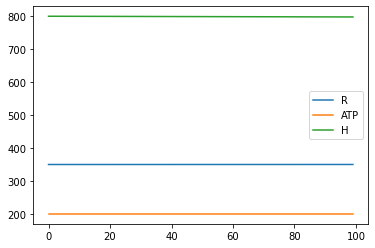

In [18]:
def backeuler(steps = 100, I=100, Ro = Ro, ATPo = ATPo, Ho = Ho, dt = dt*.01, error = error):
    x0 = [Ro, ATPo, Ho]
    a = len(x0)
    sol = np.zeros((steps, a))
    sol[0] = x0
    for i in range(steps-1):
        guess = sol[i]
        jaco = np.array(dt*dF(guess), dtype = np.float)
        
        DE, jpq = Hmodel(sol[i], Ro = Ro, ATPo = ATPo, I=I)
        
        #need function dF to evaluate Jacobian at at x
        xn = guess - np.matmul(inv(np.subtract(eye(a),jaco)),dt*DE)
        
        while norm(xn-guess) > error:
            guess = xn
            
            jaco = np.array(dt*dF(guess), dtype = np.float)
            
            xdiff = np.subtract(guess, sol[i])
            
            DE, jpq = Hmodel(guess, Ro = Ro, ATPo = ATPo, I=I)
            
            xn = guess - np.matmul(inv(np.subtract(eye(a), jaco)),np.subtract(xdiff, dt*DE))
        sol[i+1] = xn
    for k in range(a):
        y = [x[k] for x in sol]
        plt.plot(range(steps), y, label="{}".format(vs[k]))
    print(Hmodel(sol[-1], Ro = Ro, ATPo = ATPo, I=I))
    plt.legend()
    plt.show()
backeuler()

In [14]:
#numerical simulation
@interact(dt = (.00001, .01, .00001), I=(0,2000,10), steps=(10, 50000, 1), knpq = (.001, 1, .001), kr = (.01, 20000, .01), Ho = (0,100, 1))
def getss(steps = steps, dt = dt, Ro = Ro, Ho=Ho, ATPo=ATPo, PGAo = PGAo, Po=Po, ADPo=ADPo, I=I, O=O, C=C, knpq=.5, kr = kr):
    x0 = [Ro, ATPo, Ho]
    a = len(x0)
    sol = np.zeros((steps, a))
    sol[0] = x0
    for i in range(steps-1):
        DE, jpq = Hmodel(sol[i], I=I, knpq=knpq, C=C, O=O, kr =kr, ATPo = ATPo, Ro = Ro, PGAo = PGAo, Po=Po, ADPo=ADPo)
        step = DE*dt
        sol[i+1] = np.add(sol[i], step)
        
    
     
    R = sol[-1][0]
    fC = kc*C
    fO = ko*O
    fR = kr*R
    jcA = Et/((1/kERC) + (1/(fC+fO)) + 1/fR - 1/(fC+fO+fR))
    
    return jcA


interactive(children=(IntSlider(value=10000, description='steps', max=50000, min=10), FloatSlider(value=0.001,…

In [12]:
def steadystate(I, C, tsteps=15000, Ro=Ro, ATPo=ATPo, Ho=Ho, PGAo = PGAo, Po=Po, ADPo=ADPo, error = .01, dt = .001):
    sol= np.zeros((tsteps, 3))
    x=sol[0] = [Ro, ATPo, Ho]
    print(I)
    for i in range(tsteps-1):
        DE, jpq = Hmodel(sol[i], I=I, knpq=knpq, C=C, O=O, kr =kr, ATPo = ATPo, Ro = Ro, PGAo = PGAo, Po=Po, ADPo=ADPo)
        step = DE*dt
        sol[i+1] = np.add(sol[i], step)
        
    
    R = sol[tsteps-1][0]
    
    fC = kc*C
    fO = ko*O

    fR = kr*R
    jcA = Et/((1/kERC) + (1/(fC+fO)) + 1/fR - 1/(fC+fO+fR))
    return jcA

In [13]:
@interact()
def Isteadystate(Irange = 1000, steps = 10, Ro=Ro, ATPo=ATPo, Ho=Ho, C=C, PGAo = PGAo, Po=Po, ADPo=ADPo, error = .01, dt = .001):
    Is = np.linspace(.1, Irange, steps)
    S = []
    print('test')
    for I in Is:
        jcA = steadystate(I, C, Ro=Ro, ATPo=ATPo, Ho=Ho, PGAo = PGAo, Po=Po, ADPo=ADPo, error = error, dt = dt)
        S.append(jcA)
        print(I, jcA)
    plt.plot(Is, S)
    plt.show()

interactive(children=(IntSlider(value=1000, description='Irange', max=3000, min=-1000), IntSlider(value=10, de…